In [1]:
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from src.lexrank import degree_centrality_scores

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

In [2]:
DATASET = DATASETS[1]
DATA_DIR = f'/scratch/korunosk/data'
EMBEDDINGS_DIR = os.path.join(DATA_DIR, 'BERT_sent')

## Experiments

In [3]:
def load_and_extract_topic(data_dir, topic_id):
    topic = load_data(data_dir, topic_id, encoded=True)
    return extract(topic)

In [4]:
def execute_experiment(data_dir, tac, experiment):
    data   = [ load_and_extract_topic(data_dir, topic_id) for topic_id in tac ]
    scores = [ experiment(d) for d in data ]

    return np.array(scores)

In [5]:
def experiment_average_pairwise_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: average_pairwise_distance(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_semantic_volume(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    metric = lambda i: semantic_volume(np.array(summary_pts[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_semantic_spread(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: semantic_spread(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_word_mover_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_hist = []
    # document_hist = np.empty(document_embs.shape[0])
    # document_hist.fill(1 / document_embs.shape[0])
    metric = lambda i: word_mover_distance(document_embs, np.array(summary_embs[i[0]:i[1]]), document_hist)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_lex_rank(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    metric = lambda i: lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

## Scores

In [6]:
scores = [
    {
        'label': 'Average Pairwise Distance',
        'experiment': experiment_average_pairwise_distance 
    },
    {
        'label': 'Semantic Volume',
        'experiment': experiment_semantic_volume 
    },
    {
        'label': 'Semantic Spread',
        'experiment': experiment_semantic_spread 
    },
    {
        'label': 'Word Mover Distance',
        'experiment': experiment_word_mover_distance 
    },
    {
        'label': 'LexRank',
        'experiment': experiment_lex_rank 
    }
]

ptr = ''
print(f'=== Experiments {DATASET} ===\n')
for i,s in enumerate(scores):
    print('Executing "{}"'.format(s['label']))
    start = time.time()
    scores[i]['values'] = execute_experiment(os.path.join(EMBEDDINGS_DIR, DATASET), TOPICS[DATASET], s['experiment'])
    print('*** Elapsed: {:}\n'.format(format_time(time.time() - start)))
    ptr += '{:30} {:.4}\n'.format(s['label'], np.mean(scores[i]['values']))
    del s['experiment']
print('\n=== Results ===\n')
print(ptr)

=== Experiments TAC2009 ===

Executing "Average Pairwise Distance"
*** Elapsed: 0:00:05

Executing "Semantic Volume"
*** Elapsed: 0:00:06

Executing "Semantic Spread"
*** Elapsed: 0:00:05

Executing "Word Mover Distance"
*** Elapsed: 0:00:05

Executing "LexRank"
*** Elapsed: 0:00:07


=== Results ===

Average Pairwise Distance      0.1198
Semantic Volume                0.1677
Semantic Spread                0.1598
Word Mover Distance            -0.04091
LexRank                        0.1981



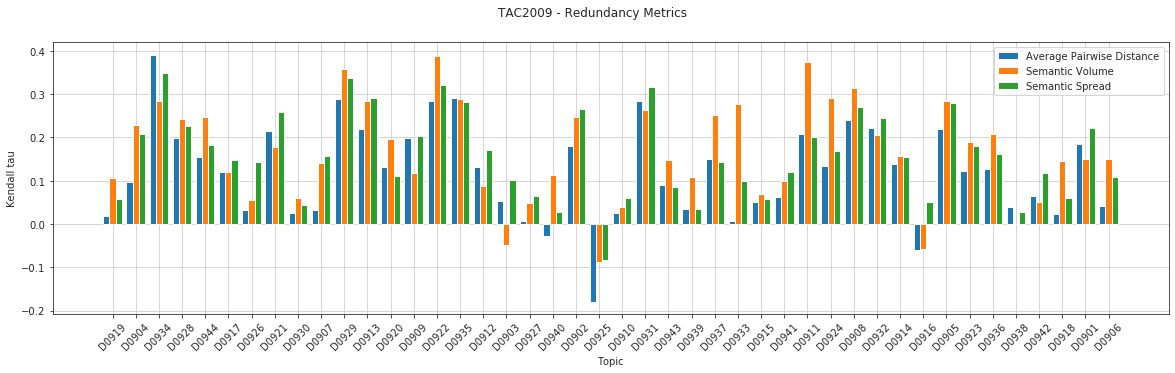

In [7]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(f'{DATASET} - Redundancy Metrics')
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores[:3])
plt.legend(loc='upper right')
plt.grid()
plt.show()

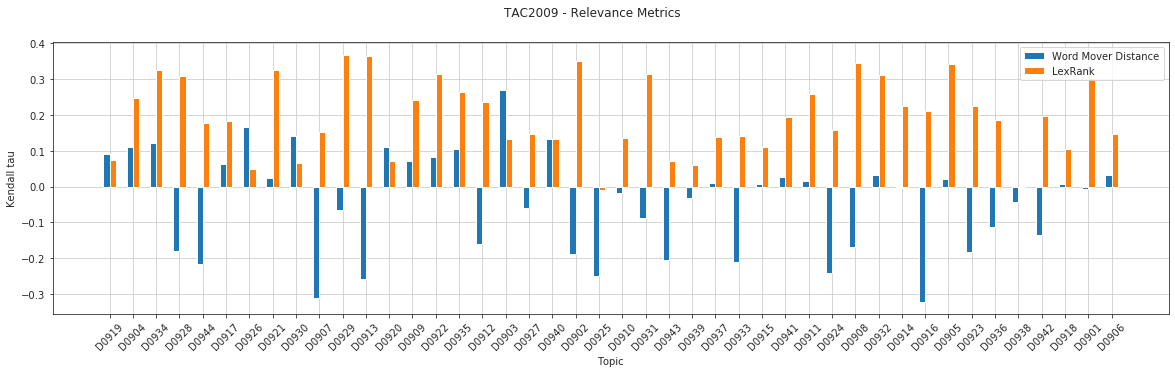

In [8]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(f'{DATASET} - Relevance Metrics')
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores[3:])
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Experimental

### Make data

In [9]:
data = []

for dataset_id in DATASETS:
    print(dataset_id)
    for topic_id in TOPICS[dataset_id]:
        document_embs, summary_embs, indices, pyr_scores, summary_ids = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, dataset_id), topic_id)
        document_embs = np.array(document_embs)

        document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))

        for p,i in enumerate(indices):
            data.append({
                'Dataset ID': dataset_id,
                'Topic ID': topic_id,
                'Summary ID': summary_ids[p],
                'Average Pairwise Distance': average_pairwise_distance(np.array(summary_embs[i[0]:i[1]])),
                'Semantic Volume': semantic_volume(np.array(summary_pts[i[0]:i[1]])),
                'Semantic Spread': semantic_spread(np.array(summary_embs[i[0]:i[1]])),
                'Word Mover Distance': word_mover_distance(document_embs, np.array(np.array(summary_embs[i[0]:i[1]])), []),
                'LexRank': lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores),
                'Pyramid Score': pyr_scores[p]
            })

df = pd.DataFrame(data, columns=data[0].keys())

TAC2008
TAC2009


In [10]:
def fix(df):
    df = df.corr(method='kendall').loc['Pyramid Score']
    df.name = ''
    return df.drop('Pyramid Score')
df_tmp = df.groupby(['Dataset ID', 'Topic ID']).apply(fix).reset_index()
df_tmp.groupby('Dataset ID').mean()

/home/korunosk/.conda/envs/dlab/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


,Average Pairwise Distance,Semantic Volume,Semantic Spread,Word Mover Distance,LexRank
Dataset ID,,,,,
TAC2008,-0.015701,0.040861,0.027107,-0.049240,0.061593
TAC2009,0.119815,0.167713,0.159819,-0.040908,0.198115


In [11]:
df_tmp = df[df['Dataset ID'] == DATASET]

In [12]:
def print_sentences(summary):
    for i, sentence in enumerate(summary):
        print('{:3}. {}'.format(i+1, sentence))

In [13]:
tac = load_data(DATA_DIR, DATASET, encoded=False)

In [14]:
# Topic ID with high correlation coefficient (chosen from the plot above)
TOPIC_ID = 'D0934'
documents, summaries, indices, _, summary_ids = extract(tac[TOPIC_ID])

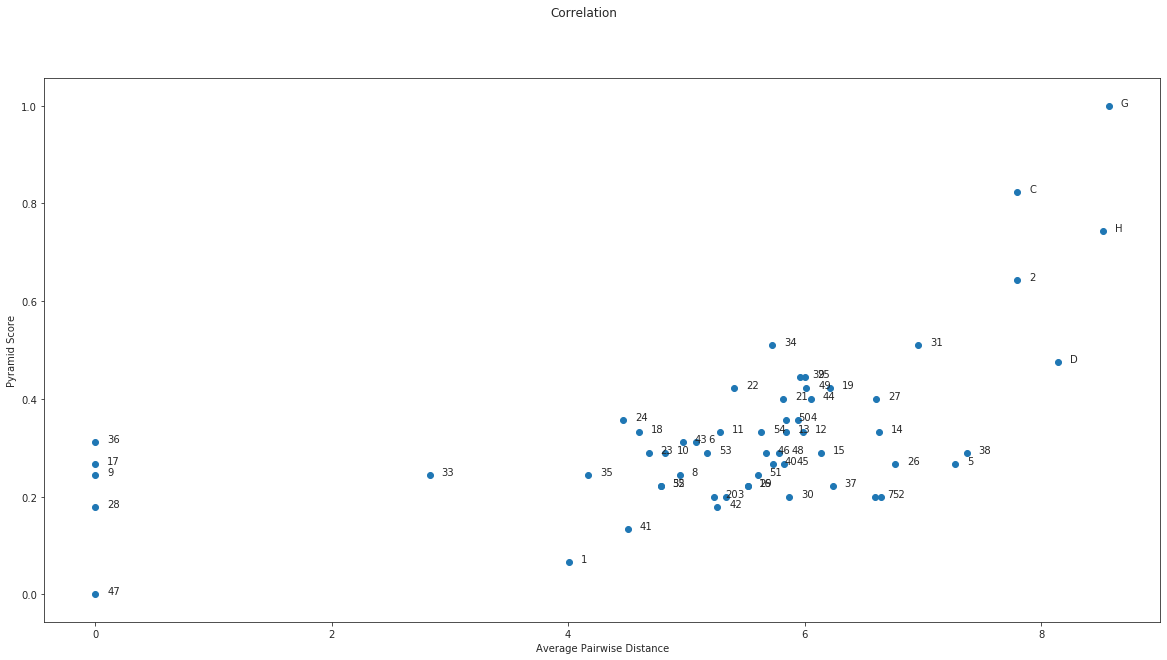

In [17]:
# Scatter plot of metric vs Pyramid score
fig = plt.figure(figsize=(20,10))
fig.suptitle('Correlation')
ax = fig.add_subplot(1,1,1)
plot_corr(ax, df_tmp, TOPIC_ID, 'Average Pairwise Distance')
plt.show()

In [17]:
# Print sentences in summary where the metric and the Pyramid score agree
SUMMARY_ID = int(np.where(np.array(summary_ids) == 'G')[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. On October 23, Tunisian doctors were allowed to see Yasser Arafat, who was hospitalized two days later.
  2. Rumors on his ailment and condition began spreading.
  3. On October 28, his move to a Paris hospital was approved.
  4. He entered the intensive care unit on November 3.
  5. As contradicting reports of his condition continued, rumors on his funeral and burial began to surface.
  6. Arafat supposedly wanted a Jerusalem grave.
  7. This is opposed by Israel, which wants burial in the Gaza Strip.
  8. Palestinian sources mentioned Ramallah.
  9. Egypt offered to host the funeral.
 10. Agreement among Palestinian and Israeli officials was reached on November 9.


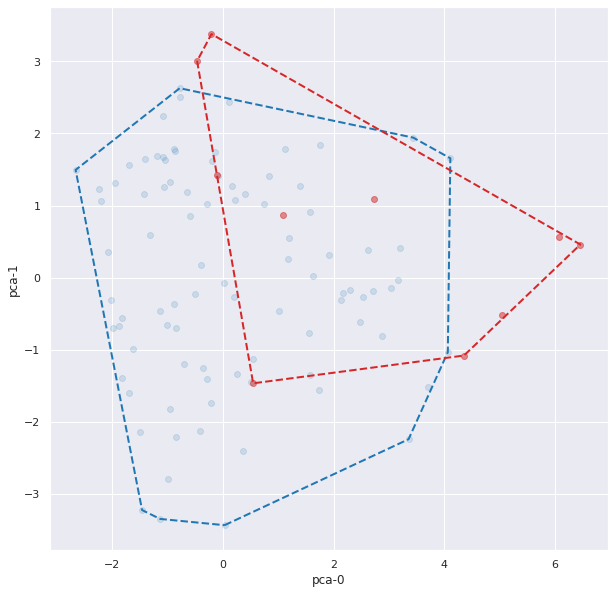

In [18]:
# Plot projection of such summary
document_embs, summary_embs, indices, _, _ = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, DATASET), TOPIC_ID)
document_embs = np.array(document_embs)

document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
plot_hull(ax1, '', 'pca', document_pts, summary_pts[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])
plt.show()

### Why do certain summaries have 0 Pyramid score?

In [19]:
# Ratio between the number of summaries with 0 Pyramid score and the ones with > 0 Pyramid score
df_tmp[df_tmp.pyr_score == 0].groupby('topic_id').apply(len) / df_tmp[df_tmp.pyr_score > 0].groupby('topic_id').apply(len) * 100

topic_id
D0901     5.357143
D0902    11.538462
D0903    18.000000
D0904     9.259259
D0905    28.260870
D0906     1.724138
D0907    18.000000
D0908          NaN
D0909     1.724138
D0910     3.508772
D0911          NaN
D0912    18.000000
D0913     3.508772
D0914     1.724138
D0915     3.571429
D0916     3.508772
D0917     5.454545
D0918    13.461538
D0919          NaN
D0920    20.408163
D0921          NaN
D0922     5.357143
D0923    11.320755
D0924     5.357143
D0925     3.508772
D0926     5.357143
D0927     9.433962
D0928     7.272727
D0929     3.571429
D0930    11.320755
D0931     9.259259
D0932     1.724138
D0933    20.408163
D0934     1.724138
D0935     5.357143
D0936     3.508772
D0937     3.508772
D0938     5.357143
D0939     1.724138
D0940     5.357143
D0941     1.754386
D0942    22.916667
D0943     3.508772
D0944    13.461538
dtype: float64

In [20]:
# Summaries with 0 Pyramid score
df_tmp[df_tmp.pyr_score == 0].head()

,average_pairwise_distance,dataset_id,lex_rank,pyr_score,semantic_spread,semantic_volume,summ_id,topic_id
3038,8.359042,TAC2009,11.793768,0.0,1.539979e+11,21.268761,5,D0904
3042,0.000000,TAC2009,1.965628,0.0,0.000000e+00,0.000000,9,D0904
3050,4.126753,TAC2009,3.931256,0.0,8.932643e+03,0.000000,17,D0904
3061,4.450281,TAC2009,5.896884,0.0,1.777571e+05,0.247354,28,D0904
3072,8.895357,TAC2009,15.176381,0.0,4.440664e+14,11.292881,39,D0904


In [21]:
# Print sentences in summaries with 0 Pyramid score, per topic
for topic_id, df_group in df_tmp[df_tmp.pyr_score == 0].groupby('topic_id'):
    print(f'=== {DATASET} ===\n')
    for _, row in df_group.iterrows():
        document_embs, summary_embs, indices, _, _ = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, DATASET), topic_id)
        summary_id = int(np.where(np.array(summary_ids) == row['summ_id'])[0])
        print(f'   Summary ID: {summary_id}\n')
        print_sentences(summaries[indices[summary_id][0]:indices[summary_id][1]])
        print()

=== TAC2009 ===

   Summary ID: 8

  1. Palestinian leader Yasser Arafat would

   Summary ID: 24

  1. Herewith a summary of events related to Palestinian leader Yasser Arafat's health situation.
  2. Senior Palestinian official Yasser Abed Rabbo denied on Tuesday reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  3. An agreement on funeral arrangements to be made in the aftermath of Yasser Arafat's death was reached Tuesday by Israeli and Palestinian officials, a senior Palestinian official said on condition of anonymity.
  4. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat, a senior Israeli official told AFP Tuesday.

   Summary ID: 27

  1. Nov 7: French Foreign Minister Michel Barnier say Arafat is alive but in serious condition.

=== TAC2009 ===

   Summary ID: 0

  1. An agreement on funeral arrangements to be made in the aftermath of Yasser Arafat's death was reached Tuesday by Isr

   Summary ID: 8

  1. Palestinian leader Yasser Arafat was not dead at 3:30 pm, a French official said.

   Summary ID: 16

  1. Egypt is reportedly to have offered to hold a funeral service for Arafat, partly to spare Arab leaders from Israeli security measures they have to go through if they go to the Palestinian territories to pay their last respect to the Palestinian leader.
  2. Israel is preparing for a possible escalation of violence in the West Bank and Gaza after the death of Arafat, the Israeli defense minister, Shaul Mofaz, told the Cabinet on Sunday, Israeli officials said.Oct 29: Arafat heads to the Jordanian capital Amman on board a helicopter and is then transferred to a French military jet that transports him to a military hospital on the outskirts of Paris.Oct 31: Sharon says he is opposed to Arafat, once dead, being buried in Jerusalem's Al-Aqsa mosque compound.

   Summary ID: 27

  1. Nov 2: Doctors issue a medical bulletin saying Arafat's illness is not leukemia b

   Summary ID: 38

  1. Israel is preparing for a possible escalation of violence after the death of Arafat the Israeli defense minister
  2. Top Palestinian officials abruptly postponed a trip to Paris to ascertain the real condition of ailing leader Yasser Arafat after critical comments by his wife.
  3. Herewith a summary of events related to Palestinian leader Yasser Arafat's health situation.
  4. Senior Palestinian official Yasser Abed Rabbo denied reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  5. Palestinian leader Yasser Arafat would be buried at his headquarters in the West Bank town of Ramallah.
  6. Ahmed Sobeih told Xinhua late Tuesday.

=== TAC2009 ===

   Summary ID: 4

  1. Palestinian leader Yasser Arafat was not dead at 3:30 pm.
  2. Senior Palestinian official Yasser Abed Rabbo denied on Tuesday reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  3. An agreement on funeral arrangements to be made

   Summary ID: 21

  1. Nov 7: French Foreign Minister Michel Barnier say Arafat is alive but in serious condition.
  2. Oct 30: Palestinian officials deny reports that Arafat is suffering from leukemia or that he has lost his faculties.
  3. As Arafat had struggled for life, there has been wild guess as to where he might be buried and where to hold the funeral service.

   Summary ID: 24

  1. Palestinian foreign minister  Nabil Shaath  denied a claim by a fellow cabinet minister Tuesday that  Arafat  has died in a  French  military hospital but said he was very ill.
  2. Arafat 's condition was described as unchanged by a spokesman of the French  military hospital in  Paris  where  Arafat  is variously said to be in an irreversible coma, a reversible one or no coma at all.

   Summary ID: 27

  1. The 13 main Palestinian factions held an emergency meeting Tuesday to discuss arrangements to follow an official announcement that Palestinian leader Yasser Arafat has died, an Islamic Jiha

   Summary ID: 16

  1. Herewith a summary of events related to Palestinian leader Yasser Arafat's health situation.

   Summary ID: 24

  1. However, a high-ranking Palestinian security official in Gaza, who spoke on condition of anonymity, said that he expects that Arafat's death would be announced within the coming few hours.
  2. Senior Palestinian  official  Yasser Abed Rabbo  denied on Tuesday reports saying that  Palestinian  leader  Yasser Arafat  has died in a  French  hospital.
  3. Palestinian foreign minister  Nabil Shaath  denied a claim by a fellow cabinet minister Tuesday that  Arafat  has died in a  French  military hospital but said he was very ill.

   Summary ID: 27

  1. Yasser Arafat is in a"very difficult and serious"situation, the Palestinian foreign minister said Tuesday after he and other officials met their critically ill leader's doctors.

   Summary ID: 30

  1. The 13 main Palestinian factions held an emergency meeting Tuesday to discuss arrangements to fol

   Summary ID: 8

  1. Palestinian leader Yasser Arafat would

   Summary ID: 12

  1. The Palestinian leader's advisor Nabil Abu Rudeina says Arafat is "OK".
  2. Palestinian leader Yasser Arafat would be buried at his headquarters
  3. Top Palestinian officials abruptly postponed a trip to Paris on Monday to ascertain the real condition of ailing leader Yasser Arafat after critical comments by his wife, a spokesman said Monday.
  4. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat, a senior Israeli official told AFP Tuesday.

   Summary ID: 16

  1. Egypt is reportedly to have offered to hold a funeral service for Arafat, partly to spare Arab leaders from Israeli security measures they have to go through if they go to the Palestinian territories to pay their last respect to the Palestinian leader.

   Summary ID: 27

  1. Arafat to be buried in Ramallah: sources.

   Summary ID: 30

  1. No official announcement on the dea

   Summary ID: 45

  1. His condition later deteriorated.
  2. He suddenly went into a deep coma and death seemed imminent.
  3. Palestinian sources said he would be buried in the West Bank.
  4. Ariel Sharon said he could be buried in Gaza.
  5. Egypt might host the funeral services.

=== TAC2009 ===

   Summary ID: 24

  1. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat, a senior Israeli official told AFP Tuesday.
  2. Herewith a summary of events related to Palestinian leader Yasser Arafat's health situation.
  3. Senior Palestinian official Yasser Abed Rabbo denied on Tuesday reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  4. An agreement on funeral arrangements to be made in the aftermath of Yasser Arafat's death was reached Tuesday by Israeli and Palestinian officials, a senior Palestinian official said on condition of anonymity.
  5. Israeli and Palestinian officials will begin 

   Summary ID: 8

  1. Palestinian leader Yasser Arafat was not dead at 3:30 pm (1430 GMT), a French official said.Herewith a summary of events related to Palestinian leader Yasser Arafats health situation.The Palestinian leaders advisor Nabil Abu Rudeina says Arafat is OK.He did not say what the diagnosis was, or whether the delegation had actually seen Arafat face to face.The statement made public by General Christian Estripeau is still valid at 3:30 pm, he said.Two senior Palestinian officals Nasser el-Qidwa and Leila Shahid also denied that Arafat was dead.
  2. However, a high-ranking Palestinian security official in Gaza, who spoke on condition of anonymity, said that he expects that Arafat's death would be announced within the coming few hours.

   Summary ID: 16

  1. An agreement on funeral arrangements to be made in the aftermath of Yasser Arafat's death was reached Tuesday by Israeli and Palestinian officials, a senior Palestinian official said on condition of anonymity.

  

   Summary ID: 16

  1. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat, a senior Israeli official told AFP Tuesday.

   Summary ID: 21

  1. " We are in the process of discussing the steps to be taken when the death of president Arafat is officially announced," said Khaled al - Batch.
  2. Egypt is reportedly to have offered to hold a funeral service for Arafat, partly to spare Arab leaders from Israeli security measures they have to go through if they go to the Palestinian territories to pay their last respect to the Palestinian leader.
  3. Israel is preparing for a possible escalation of violence in the West Bank and Gaza after the death of Arafat, the Israeli defense minister, Shaul Mofaz, told the Cabinet on Sunday, Israeli officials said.Oct 29: Arafat heads to the Jordanian capital Amman on board a helicopter and is then transferred to a French military jet that transports him to a military hospital on the outskirts

   Summary ID: 52

  1. - French presidency announces in late afternoon that it has accepted a request by the Palestinian Authority for Arafat to be
  2. Top Palestinian officials abruptly postponed a trip to Paris on Monday to ascertain the real condition of ailing leader Yasser Arafat after critical comments by his wife, a spokesman Monday.
  3. Herewith a summary of events related to Palestinian leader Yasser Arafat's health situation.



### Why do scores not agree?

In [22]:
# Print topics with 0 Pyramid score, ordered by number of summaries
df_tmp[df_tmp.pyr_score == 0].groupby('topic_id').apply(len).sort_values().head()

topic_id
D0941    1
D0939    1
D0932    1
D0906    1
D0934    1
dtype: int64

In [23]:
# Extract the un-encoded data of one such topic
TOPIC_ID = 'D0941'
documents, summaries, indices, _, summary_ids = extract(tac[TOPIC_ID])

In [24]:
# Select the data for the topic from the dataframe
df_tmp = df[df.topic_id == TOPIC_ID].sort_values(by='pyr_score')

In [25]:
# Print sentences in worst summary
SUMMARY_ID = int(np.where(np.array(summary_ids) == df_tmp.iloc[0].summ_id)[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. "This will be like a Jules Verne adventure," she said.


In [26]:
# Print sentences in best summary
SUMMARY_ID = int(np.where(np.array(summary_ids) == df_tmp.iloc[-1].summ_id)[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. The Huygens space probe, built and managed by the European Space Agency, was carried by NASA's Cassini spacecraft on a 7-year journey to Saturn.
  2. It separated successfully from Cassini on Christmas Eve and began a 2.5-million-mile 20-day descent to Saturn's largest moon Titan, the only moon in the solar system that has atmosphere.
  3. During its descent it will sample Titan's atmosphere.
  4. Everything must work perfectly because there is no way to adjust Huygens' course.
  5. Progress was being carefully followed by NASA and the 16 European nations involved in the project.


### Combination of Relevance and Redundancy metrics

In [128]:
for alpha in np.linspace(0,1,10):

    def experiment_comb(document_embs, summary_embs, indices, pyr_scores):
        metric_1 = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
        scores_1 = calculate_scores(indices, metric_1)

        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
        metric_2 = lambda i: lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores)
        scores_2 = calculate_scores(indices, metric_2)

        scores = (1-alpha) * scores_1 + alpha * scores_2

        return kendalltau(pyr_scores, scores)[0]

    print(np.mean(execute_experiment(tac_encoded, experiment_comb)))

### Regression analysis

In [129]:
df_train, df_test = df[df['dataset_id'] == DATASETS[0]], df[df['dataset_id'] == DATASETS[1]]
df_train.head()

,dataset_id,topic_id,summ_id,average_pairwise_distance,semantic_volume,semantic_spread,word_mover,lex_rank,pyr_score
0,TAC2008,D0841,0,5.931439,2.935318,1.458850e+07,8.152747,6.541451,0.049
1,TAC2008,D0841,1,6.321484,8.034078,1.649654e+07,8.692294,6.271436,0.195
2,TAC2008,D0841,2,5.931439,2.935318,1.458850e+07,8.152747,6.541451,0.049
3,TAC2008,D0841,3,5.663631,0.961197,1.050729e+07,8.478753,6.541451,0.415
4,TAC2008,D0841,4,6.291665,2.105044,5.957084e+05,8.534398,4.380111,0.073


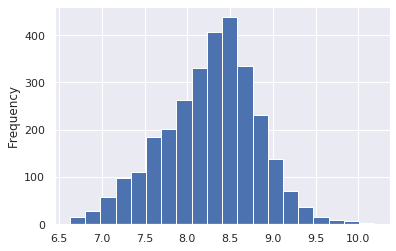

In [130]:
df_train['word_mover'].plot(kind='hist', bins=20);

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X = df.iloc[:,3:-1].values
y = df.iloc[:,-1].values
s = df.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=s)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4173, 5), (1392, 5), (4173,), (1392,))

In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV, Lasso
from sklearn.metrics import mean_squared_error

clf = RidgeCV().fit(X_train, y_train)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.06386776685950823, 0.07177668025730843)

In [137]:
mean_squared_error(clf.predict(X_train), y_train), mean_squared_error(clf.predict(X_test), y_test)

(0.03507858220030431, 0.034161095359737166)

In [138]:
clf.coef_

array([-0.02133141,  0.00859164, -0.00759842, -0.0019213 ,  0.05781679])

### Exporting best summaries for all datasets

In [25]:
for dataset in DATASETS:
    tac = load_data(DATA_DIR, dataset, encoded=True)
    print(f'{dataset}')
    
    for topic_id, topic in tac.items():
        document_embs, summary_embs, indices, pyr_scores, summary_ids = extract(topic)

        m = np.argsort(-pyr_scores)

        embeddings = {
            'tag': f'{DATASET}:{topic_id}:System Summaries:BERT',
            'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
            'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
        }

        make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

TAC2008
TAC2009


# Plotting BERT

In [70]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid scores
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

## System Summaries

### TensorBoard

In [12]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:System Summaries:BERT',
    'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
    'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

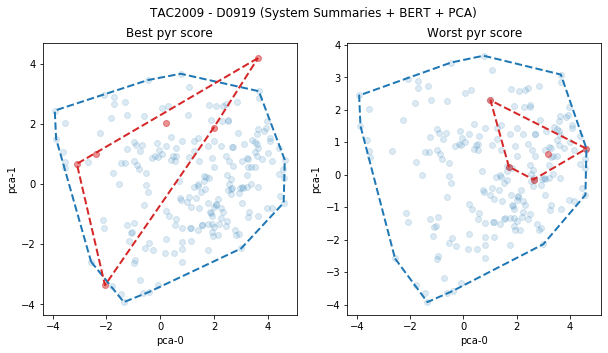

In [13]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + PCA)')
ax1 = fig.add_subplot(1,2,1)
plot('pca', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('pca', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 473 samples in 0.015s...
[t-SNE] Computed neighbors for 473 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 473 / 473
[t-SNE] Mean sigma: 2.878953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.332146
[t-SNE] KL divergence after 2400 iterations: 0.672893


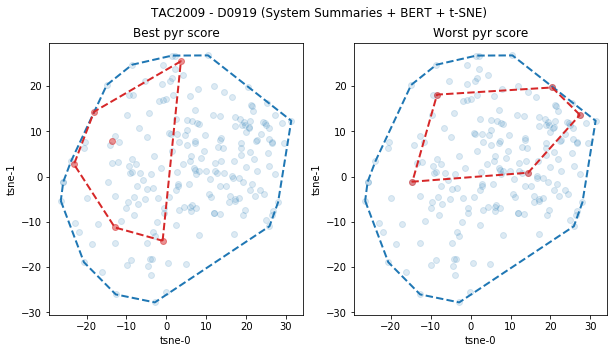

In [14]:
document_pts, summary_pts = project_tsne(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + t-SNE)')
ax1 = fig.add_subplot(1,2,1)
plot('tsne', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('tsne', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

## Extractive Summarization by Maximizing Semantic Volume

In [15]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [16]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:BERT',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

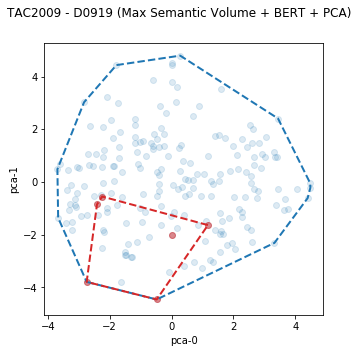

In [17]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.004s...
[t-SNE] Computed neighbors for 208 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 2.745973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.173157
[t-SNE] KL divergence after 1050 iterations: 0.777134


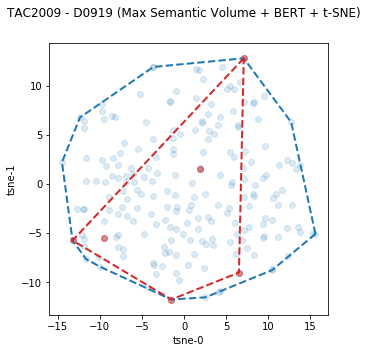

In [18]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Plotting SVD

In [19]:
### Load
tac = load_data(DATASET, encoded=False)

### Extract
topic = tac[TOPIC]
documents, summaries, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd

### Count bigrams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), binary=True)
X = vectorizer.fit_transform(documents)

# If bigram b is present in s_i,
# we let s_i,b be the number of documents
# in the corpus that contain bigram b, and
# zero otherwise.
nd = X.sum(axis=0)
S = X.multiply(nd)

### Decompose
U, Sigma, VT = randomized_svd(S, n_components=100, n_iter=5, random_state=42)

# We then perform singular value decomposition (SVD)
# on S. We use U_K as the sentence representations.

In [21]:
document_embs = U

## Extractive Summarization by Maximizing Semantic Volume

In [22]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [23]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:SVD',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

###  PCA

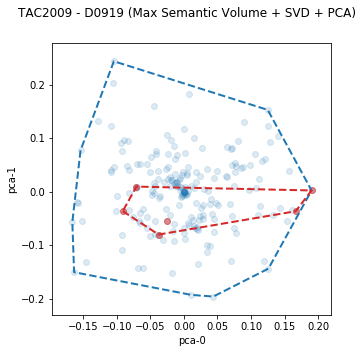

In [24]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.001s...
[t-SNE] Computed neighbors for 208 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.240379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.293152
[t-SNE] KL divergence after 1400 iterations: 1.076915


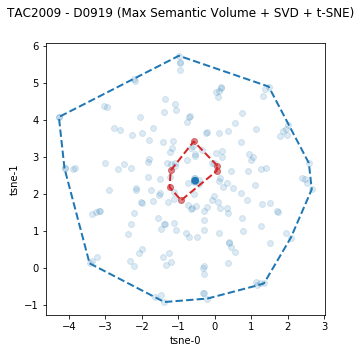

In [25]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Interactive plot BERT

In [ ]:
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

In [26]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

### PCA

In [27]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(summary_pts[indices[m[i],0]:indices[m[i],1]], f'sum-{i+1}') for i in range(len(m))], ignore_index=True)

In [28]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           title=DATASET + ' - ' + TOPIC,
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…